# Preliminaries: Inspect and Set up environment

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(datetime.datetime.now())

2021-04-25 21:56:53.919540


In [4]:
!which python

/usr/local/bin/python


In [5]:
!python --version

Python 3.7.10


In [6]:
!echo $PYTHONPATH

/env/python


In [7]:
# TODO: install any packages you need to here. For example:
#pip install unidecode

!pip install unidecode textstat
!pip install textaugment

# this is for text preprocessing and it requires python3 and spacy 
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-r56fra42
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-r56fra42
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp37-none-any.whl size=11743 sha256=13a0e56067678b3a87aae8e1e891120dd0c8924070cf66fd846338d01fefde1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-tnyco3gp/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [10]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Question 1: Sentiment Analysis via Shallow ML



In [11]:
# DO NOT MODIFY THIS CELL

# First, we'll read the provided labeled training data
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1b8MAiN-xBdk6scM-DnufkuijDZivZJqM")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


In [12]:
# Verify if labels are distributed in a balanced way
df['Polarity'].value_counts()

0    1213
1    1187
Name: Polarity, dtype: int64

In [13]:
df.shape

(2400, 2)

In [14]:
# Remove the duplicates
df = df.drop_duplicates('Sentence')
df.shape

(2382, 2)

### **Add Text Augmentation to improve the performance of the model.**

In [15]:
nltk.download('averaged_perceptron_tagger')
from textaugment import Wordnet
from tqdm import tqdm
from sklearn.utils import shuffle

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [16]:
# Data augmentation function with dataframe and number of samples as parameters

def augment_text(df,samples=1600):
    t = Wordnet()
    new_text_majority = []
    
    ##selecting the majority class samples
    df_n = df[df.Polarity==1].reset_index(drop=True)

    ## Data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):
        
            text = df_n.iloc[i]['Sentence']
            augmented_text = t.augment(text)
            new_text_majority.append(augmented_text)
    
    ## Dataframe
    new = pd.DataFrame({'Sentence':new_text_majority,'Polarity':1})
    df=shuffle(df.append(new).reset_index(drop=True))




    new_text_minority=[]

    ##selecting the minority class samples
    df_n=df[df.Polarity==0].reset_index(drop=True)

    ## Data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_n),samples)):
        
            text = df_n.iloc[i]['Sentence']
            augmented_text = t.augment(text)
            new_text_minority.append(augmented_text)
    

    ## dataframe
    new=pd.DataFrame({'Sentence':new_text_minority,'Polarity':0})
    df=shuffle(df.append(new).reset_index(drop=True))
    return df

In [17]:
df = augment_text(df)

100%|██████████| 1600/1600 [00:01<00:00, 1023.87it/s]


In [18]:
# Confirm that labels are balanced
df['Polarity'].value_counts()

0    2806
1    2776
Name: Polarity, dtype: int64

In [19]:
# See if there are null values
df.isnull().sum()

Sentence    0
Polarity    0
dtype: int64

In [20]:
# Drop the NaN values
df.dropna(inplace=True)
df.isnull().sum()

Sentence    0
Polarity    0
dtype: int64

**Add Sentiment Label Score Feature using Vander package**

In [21]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [22]:
# Create new features to improve the training steps
df['scores'] = df['Sentence'].apply(lambda review: sid.polarity_scores(review))
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['comp_score'] = df['compound'].apply(lambda c: 1 if c >=0 else 0)

In [23]:
#Funtion to get 'top N' or 'bottom N' words to remove most rare words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
def get_n_words(corpus, direction, n):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    if direction == "top":
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    else:
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=False)
    return words_freq[:n]

In [24]:
#20 most common and 600 most rare words
common_words = get_n_words(df['Sentence'], "top", 20)
rare_words = get_n_words(df['Sentence'], "bottom", 600)

%time df['Sentence'] = df['Sentence'].map(lambda x : ' '.join([w for w in x.split() if w not in rare_words]))

CPU times: user 648 ms, sys: 1.04 ms, total: 649 ms
Wall time: 648 ms


In [25]:
# DO NOT MODIFY THIS CELL

# Next, we'll split it into training and test
from sklearn.model_selection import train_test_split

X = df['Sentence']
y = df['Polarity']

# So that we can evaluate how well our model is performing, we split our training data
# into training and validation.

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

## Part 1.a: Preprocessing and FE Pipeline

Clean and preprocess the data (i.e., `X_train`) as you see necessary. Extract features from the text (i.e., vectorization using BOW and/or Bag of N-Grams and/or topics and/or lexical features). 


In [26]:
# TODO: insert code here 

import spacy
from functools import partial
def spacy_tokenize(text, nlp):
    return [x.orth_ for x in nlp(text)]

nlp = spacy.load('en', disable=['ner', 'parser', 'tagger'])
tok = partial(spacy_tokenize, nlp=nlp)

The cell below uses KGP Talkie from
https://github.com/laxmimerit/preprocess_kgptalkie.git


It requires python3 and spacy to be already downloaded on the local machine to make it work.

In [27]:
import re
import unidecode
import preprocess_kgptalkie as ps

# A nice preprocessing function that we can pass to CountVectorizer/TfidfVectorizer
def preprocess(doc):

    # Lowercase everything
    res = doc.lower()
    
    # Remove any "weird" characters
    res = unidecode.unidecode(res)
    
    SYM_REPLACE = re.compile('[/(){}\[\]\|@,;]')
    REM_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    res = re.sub(r'\d+', '', res)
    res = ps.remove_emails(res)
    res = ps.remove_urls(res)
    res = ps.remove_html_tags(res)
    res = ps.remove_accented_chars(res)
    res = ps.remove_special_chars(res)
    res = SYM_REPLACE.sub(' ', res) 
    res = REM_SYMBOLS_RE.sub('', res) 

    # Create Lemmatizer object
    wnl = WordNetLemmatizer()
    list2 = nltk.word_tokenize(res)
    res = ' '.join([wnl.lemmatize(words) for words in list2])

    # Remove stopwords
    all_stopwords = nlp.Defaults.stop_words
    text_tokens = word_tokenize(res)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
    res = (" ").join(tokens_without_sw)

    return res

In [28]:
df['Sentence'] = df['Sentence'].apply(preprocess)

In [29]:
def doc_length(corpus):
    #print(corpus)
    return np.array([len(doc) for doc in corpus]).reshape(-1, 1)

def num_exclamation_marks(corpus):
    return np.array([doc.count('!') for doc in corpus]).reshape(-1, 1)

def generate_sentiment_score(corpus):
  score_dict = [sid.polarity_scores(doc) for doc in corpus]
  score = []
  for key in score_dict:
    #print(key['compound'])
    score.append(key['compound'])

  return np.array(score).reshape(-1, 1)


In [30]:
vectorizer = CountVectorizer(preprocessor=preprocess,  tokenizer=tok, min_df=2, 
                             max_df=0.5, max_features=1000,
                             stop_words='english', ngram_range=(1, 2))

## Part 1.b: Model Training/Tuning/Cross Validation

Use your favorite shallow ML algorithm (such as decision trees, KNN, random forest, boosting variants) to train a classification model.  Don’t forget everything that we’ve learned in the machine learning course: hyperparameter tuning, cross validation, handling imbalanced data, etc. Make reasonable decisions and try to create the best-performing model that you can.


In [31]:
# TODO: insert code here 

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import AdaBoostClassifier

# Random Forest
RF = RandomForestClassifier(criterion='entropy', random_state=1)

# We will "union" together the BOW features and the custom-created features we created

feature_processing =  FeatureUnion([ 
    ('bow', Pipeline([('vectorizer', vectorizer), ])),
    ('doc_length', FunctionTransformer(doc_length, validate=False)),
    ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
    ('sentiment_score', FunctionTransformer(generate_sentiment_score, validate=False)),  
])

Pipe = Pipeline([('features', feature_processing), ('clf', RF)])

In [32]:
# Test hyperparameter tuning with RandomSearch
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV


param_grid = {
    'features__bow__vectorizer__max_features': [500, 1000,1150,1200, 1300,2000,2500,3000,4000,5000],
    'clf__n_estimators': [10, 80, 150, 200, 225, 250, 300, 350, 400, 450, 500],
    'features__bow__vectorizer__ngram_range': [(1, 2), (1, 3)],
}

cv = StratifiedKFold(n_splits=8)
search = RandomizedSearchCV(Pipe, param_distributions=param_grid, cv=cv, n_jobs=5,  scoring='f1_macro', return_train_score=True, verbose=8)
search = search.fit(X_train, y_train)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  6.9min
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 21.7min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed: 41.4min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed: 50.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'ha', 'le', 'nt', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [33]:
print("Best parameter (CV score: %0.5f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score: 0.94407):
{'features__bow__vectorizer__ngram_range': (1, 2), 'features__bow__vectorizer__max_features': 5000, 'clf__n_estimators': 200}


In [34]:
# Model Assessment with validation data
y_val_pred = search.predict(X_val)

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(confusion_matrix(y_true = y_val, y_pred = y_val_pred))

class_names = [str(x) for x in search.best_estimator_.classes_]
print(classification_report(y_true = y_val, y_pred = y_val_pred, target_names=class_names))

[[671  26]
 [ 40 659]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       697
           1       0.96      0.94      0.95       699

    accuracy                           0.95      1396
   macro avg       0.95      0.95      0.95      1396
weighted avg       0.95      0.95      0.95      1396



## Part 1.c: Model Assessment 

Use your model to predict the sentiment of the testing data. Measure the performance (e.g., accuracy, AUC, F1-score) of your model. 

In [36]:
# DO NOT MODIFY THIS CELL

test_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1taoTluPBUMt9JkKAnlqDTrU49DJFpJGW")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [37]:
# TODO: insert code here 

# Use our pipeline to make predictions; then output predictions to a CSV file.

pred_test = search.predict(test_df['Sentence'])
my_submission = pd.DataFrame({'predicted': pred_test})
my_submission.head()

,predicted
0,1
1,1
2,1
3,1
4,1


In [38]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print("F1 Score   = {:.3f}".format(f1_score(test_df['Polarity'], pred_test, average="macro")))
print("Accuracy   = {:.3f}".format(accuracy_score(test_df['Polarity'], pred_test)))
print("AUC      = {:.3f}".format(roc_auc_score(test_df['Polarity'], pred_test)))
print("\nConfusion Matrix:")

print(confusion_matrix(y_true = test_df['Polarity'], y_pred = pred_test))

print("\n")

print("\nClassification Report:")

class_names = [str(x) for x in search.best_estimator_.classes_]
print(classification_report(y_true = test_df['Polarity'], y_pred = pred_test, target_names=class_names))

F1 Score   = 0.801
Accuracy   = 0.802
AUC      = 0.806

Confusion Matrix:
[[258  29]
 [ 90 223]]



Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       287
           1       0.88      0.71      0.79       313

    accuracy                           0.80       600
   macro avg       0.81      0.81      0.80       600
weighted avg       0.82      0.80      0.80       600



In [39]:
# Incorrect predictions
incorrect_predictions = test_df[test_df['Polarity'] != pred_test]
incorrect_predictions.shape

(119, 2)

In [40]:
incorrect_predictions.head(15)

,Sentence,Polarity
12,Not too screamy not to masculine but just righ...,1
36,"The soundtrack wasn't terrible, either.",1
38,"Still, it was the SETS that got a big ""10"" on ...",1
43,The last 15 minutes of movie are also not bad ...,1
47,I believe the screenwriter did a good job of t...,1
48,My 8/10 score is mostly for the plot.,1
49,"I won't say any more - I don't like spoilers, ...",1
51,"Not frightening in the least, and barely compr...",0
53,Not even good for camp value!,0
57,If only someone involved with it knew how to s...,0


## Part 2: Given the performance of your model, are you satisfied with the results? Explain.


The training performance was good with an F1-score of around 0.95, which is good. But I'm not completely satisfied with the final results because the testing phase had an F1-score of around 0.81. I think that doing a deeper preprocessing cleaning text operation and including more hyperparameters to vary in the hyperparameter tuning and random search would reduce this overfitting problem.

## Part 3: Show five test instances in which your model was incorrect. Dive deep and find out why your model was wrong.


Insert answer here. (Feel free to create new code cells if necessary.)

Below are five text instances which were incorrectly predicted by the model:

In [41]:
incorrect_predictions.iloc[1].Sentence

"The soundtrack wasn't terrible, either.  "

In [70]:
incorrect_predictions.iloc[2].Sentence

'Still, it was the SETS that got a big "10" on my "oy-vey" scale.  '

In [61]:
incorrect_predictions.iloc[7].Sentence

'Not frightening in the least, and barely comprehensible.  '

In [62]:
incorrect_predictions.iloc[11].Sentence

'The directing is sloppy at best.  '

In [63]:
incorrect_predictions.iloc[1].Sentence

"The soundtrack wasn't terrible, either.  "

As we can see, they all end with more space after the final "." . Some of them still have the character " ' " and others still have words which have not been lowered. Sometimes the output is not as cleaned as we expected from our preprocessing text cleaning steps.

## Part 4 (Optional): Sentiment Analysis via Deep ML

Use deep learning (e.g., RNNs and variants, CNNs and variants, and/or transformers) to build a model on the same dataset and compare the results with the Shallow ML model.

Train your own deep ML model (using, e.g., the keras library) or use a pre-trained deep ML model (using, e.g., the transformers library).

In [46]:
# TODO: Insert code here.

# Install simpletransformers
!pip install simpletransformers

# Install Unidecode
!pip install Unidecode

In [47]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [48]:
# Load dataset
DF = pd.read_csv("https://drive.google.com/uc?export=download&id=1b8MAiN-xBdk6scM-DnufkuijDZivZJqM")
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


In [49]:
# Preprocessing using Unidecode and remove duplicates

import unidecode

def preprocess(x):
  x = unidecode.unidecode(x)

  return x

DF['Sentence'] = DF['Sentence'].apply(preprocess) # Apply preprocessing
DF.drop_duplicates('Sentence', inplace=True)  # Drop duplicates

In [50]:
# Train-test split

from sklearn.model_selection import train_test_split

X = DF[['Sentence', 'Polarity']]

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [51]:
# Modeling

from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging
import sklearn

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [52]:
# Model configuration
model_args = ClassificationArgs(num_train_epochs=30, sliding_window=True, overwrite_output_dir=True, save_model_every_epoch=False, max_seq_length=400)

# Create a ClassificationModel with Roberta and Roberta-base using the model arguments specified above
model = ClassificationModel("roberta", "roberta-base", args=model_args, use_cuda=True)


INFO:filelock:Lock 140331206164240 acquired on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

INFO:filelock:Lock 140331206164240 released on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
INFO:filelock:Lock 140331206164240 acquired on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

INFO:filelock:Lock 140331206164240 released on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of R

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

INFO:filelock:Lock 140328781289552 released on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
INFO:filelock:Lock 140328781231696 acquired on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

INFO:filelock:Lock 140328781231696 released on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
INFO:filelock:Lock 140328781219280 acquired on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock


Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

INFO:filelock:Lock 140328781219280 released on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock


In [53]:
# Train the model on the entire training dataset
model.train_model(X, eval_df=X_test, f1 = sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:449: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Sliding window enabled


  0%|          | 0/2382 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: 2382 features created from 2382 samples.


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Running Epoch 0 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 1 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 2 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 3 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 4 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 5 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 6 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 7 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 8 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 9 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 10 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 11 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 12 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 13 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 14 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 15 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 16 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 17 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 18 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 19 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 20 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 21 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 22 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 23 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 24 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 25 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 26 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 27 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 28 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

Running Epoch 29 of 30:   0%|          | 0/298 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


(8940, 0.05146655398912549)

In [54]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(X_test, f1 = sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1029: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Sliding window enabled


  0%|          | 0/477 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: 477 features created from 477 samples.


Running Evaluation:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 1.0, 'tp': 239, 'tn': 238, 'fp': 0, 'fn': 0, 'f1': 1.0, 'eval_loss': 5.320495036661062e-06}


#### **Test the model with the test dataset**

In [55]:
# Load test data
DF_test = pd.read_csv("https://drive.google.com/uc?export=download&id=1taoTluPBUMt9JkKAnlqDTrU49DJFpJGW")
DF_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [56]:
predictions_test, res = model.predict(DF_test['Sentence'].tolist(), multi_label=False)
my_submission = pd.DataFrame({'predicted': predictions_test})

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Sliding window enabled


  0%|          | 0/600 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: 600 features created from 600 samples.


  0%|          | 0/75 [00:00<?, ?it/s]

#### Inspect wrong predictions 

In [57]:
wrong_predictions

[]

In [58]:
# Print confusion matrix and classification report

from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print("F1 Score   = {:.3f}".format(f1_score(DF_test['Polarity'], predictions_test, average="macro")))
print("Accuracy   = {:.3f}".format(accuracy_score(DF_test['Polarity'], predictions_test)))
print("AUC      = {:.3f}".format(roc_auc_score(DF_test['Polarity'], predictions_test)))
print("\nConfusion Matrix:")

print(confusion_matrix(y_true = DF_test['Polarity'], y_pred = predictions_test))

print("\n")

print("\nClassification Report:")

#class_names = [str(x) for x in search.best_estimator_.classes_]
print(classification_report(y_true = DF_test['Polarity'], y_pred = predictions_test))

F1 Score   = 0.928
Accuracy   = 0.928
AUC      = 0.929

Confusion Matrix:
[[274  13]
 [ 30 283]]



Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       287
           1       0.96      0.90      0.93       313

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



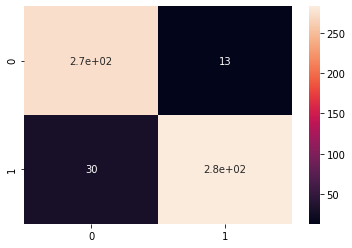

In [59]:
import seaborn as sns
%matplotlib inline
sns.heatmap(confusion_matrix(DF_test['Polarity'], predictions_test), annot=True)









**Finally, after testing many pre-trained models with different architectures using SimpleTransformers, we obtained a much better result with roberta model, where in our preprocessing we used Unidecode and dropped the duplicates.**